# Objective
Identify which metric to use for calibration of all models and ensembles

# Experiment
This notebook shows the FUSE output after calibration and compares with unregulated streamflow observations. Six experiments were conducted using RMSE and KGE metric, using the HEC-HMS configuration for a single random ensemble

* exp1 - Daily RMSE
* exp2 - Daily KGE (1 day smoothing)
* exp3 - Daily KGE (3 day smoothing)
* exp4 - Interval RMSE
* exp5 - Interval KGE (Sa = 1)
* exp6 - Interval KGE (Sa = 5)

# Conclusion
Identified experiment 5 - Interval KGE (Sa = 1) as the most suitable candidate

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import numpy as np
import pandas as pd
from scipy import stats

jtplot.style(theme='grade3')
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
# User-Supplied
file1 = '/glade/p/work/manab/ff/islandpark/output/exp1/001_222_runs_best.nc'
file2 = '/glade/p/work/manab/ff/islandpark/output/exp2/001_222_runs_best.nc'
file3 = '/glade/p/work/manab/ff/islandpark/output/exp3/001_222_runs_best.nc'
file4 = '/glade/p/work/manab/ff/islandpark/output/exp4/001_222_runs_best.nc'
file5 = '/glade/p/work/manab/ff/islandpark/output/exp5/001_222_runs_best.nc'
file6 = '/glade/p/work/manab/ff/islandpark/output/exp6/001_222_runs_best.nc'
forc = '/glade/p/work/manab/ff/islandpark/inputnew/001.nc'   #Forcing file

out1 = xr.open_dataset(file1)
out2 = xr.open_dataset(file2)
out3 = xr.open_dataset(file3)
out4 = xr.open_dataset(file4)
out5 = xr.open_dataset(file5)
out6 = xr.open_dataset(file6)
forc = xr.open_dataset(forc)
print("All variables available in the Output file: ", list(out2.variables.keys()))

# For plotting
starttime = '2011-10-01'
endtime = '2013-09-30'

All variables available in the Output file:  ['ppt', 'pet', 'obsq', 'tens_1', 'tens_1a', 'tens_1b', 'free_1', 'watr_1', 'tens_2', 'free_2', 'free_2a', 'free_2b', 'watr_2', 'swe_tot', 'swe_z01', 'swe_z02', 'swe_z03', 'swe_z04', 'swe_z05', 'swe_z06', 'swe_z07', 'evap_1', 'evap_2', 'q_instnt', 'q_routed', 'time', 'latitude', 'longitude', 'param_set']


# DAILY SIMULATIONS
### FUSE is simulated for 1970/01/01 - 2016/12/31 and calibrated for 1980/10/01 - 2014/09/31. The following plots shows daily streamflows for an example 2-year period

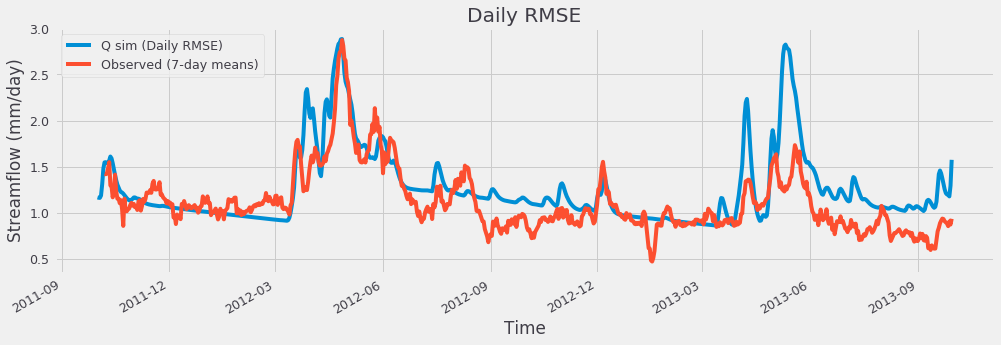

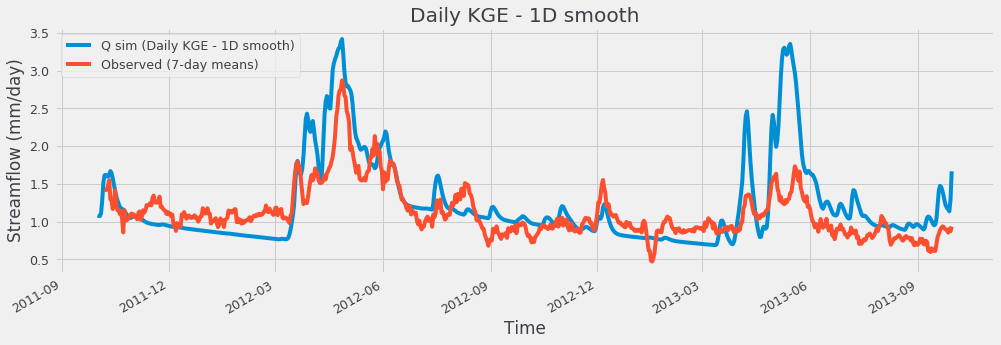

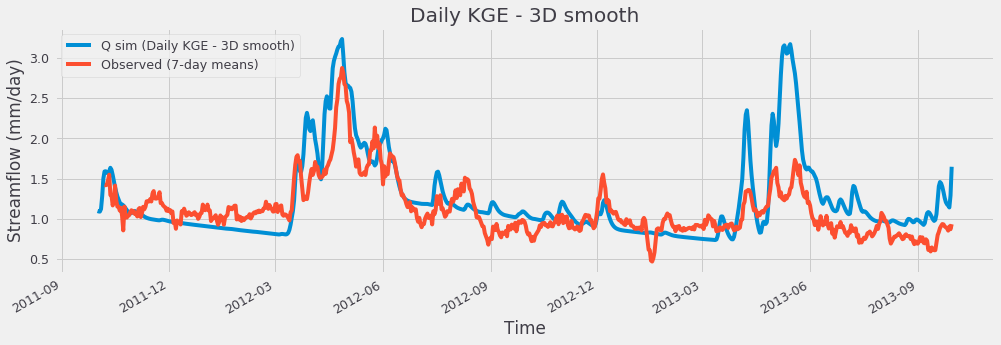

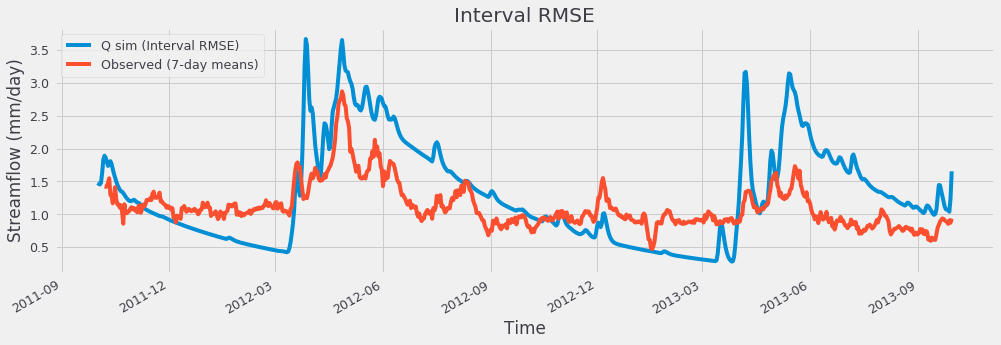

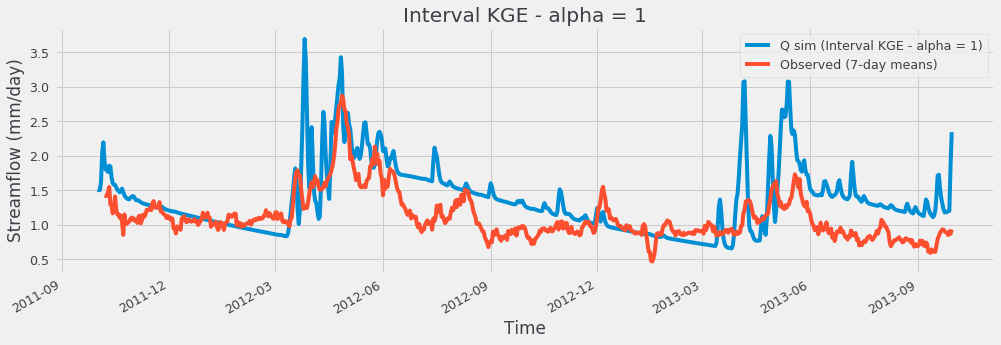

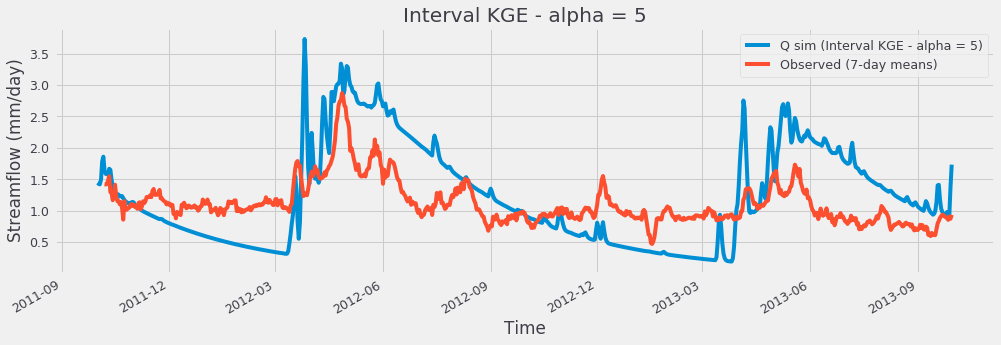

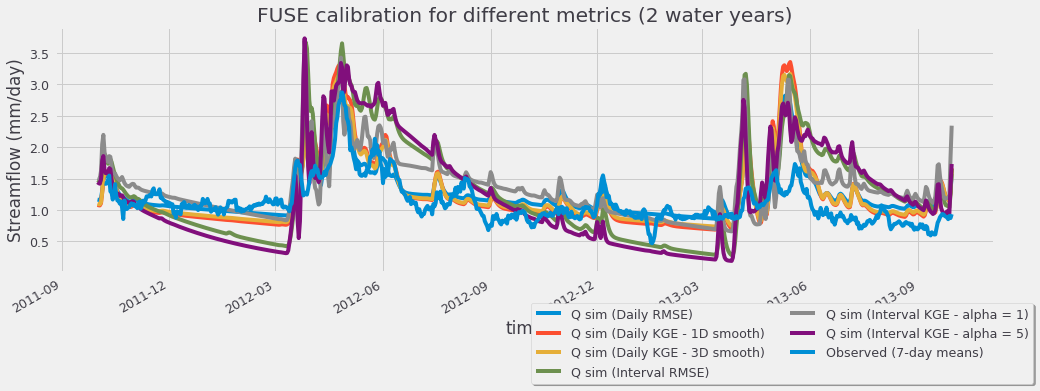

In [17]:
def plotsim(ncdat, ncvar, paramlabel, paramtitle):
    plt.style.use('fivethirtyeight')
    ncdat[ncvar].loc[starttime: endtime].plot(label = paramlabel)
    ncdat['obsq'].loc[starttime: endtime].rolling(time=7).mean().dropna('time').plot(label = 'Observed (7-day means)')
    plt.xlabel('Time')
    plt.ylabel('Streamflow (mm/day)')
    plt.title(paramtitle)
    plt.legend()
    plt.show()
    
plotsim(out1, 'q_routed', 'Q sim (Daily RMSE)', 'Daily RMSE')
plotsim(out2, 'q_routed', 'Q sim (Daily KGE - 1D smooth)', 'Daily KGE - 1D smooth')
plotsim(out3, 'q_routed', 'Q sim (Daily KGE - 3D smooth)', 'Daily KGE - 3D smooth')
plotsim(out4, 'q_routed', 'Q sim (Interval RMSE)', 'Interval RMSE')
plotsim(out5, 'q_routed', 'Q sim (Interval KGE - alpha = 1)', 'Interval KGE - alpha = 1')
plotsim(out6, 'q_routed', 'Q sim (Interval KGE - alpha = 5)', 'Interval KGE - alpha = 5')

plt.figure(figsize=(15,5))
plt.style.use('fivethirtyeight')
out1['q_routed'].loc[starttime: endtime].plot(label = 'Q sim (Daily RMSE)')
out2['q_routed'].loc[starttime: endtime].plot(label = 'Q sim (Daily KGE - 1D smooth)')
out3['q_routed'].loc[starttime: endtime].plot(label = 'Q sim (Daily KGE - 3D smooth)')
out4['q_routed'].loc[starttime: endtime].plot(label = 'Q sim (Interval RMSE)')
out5['q_routed'].loc[starttime: endtime].plot(label = 'Q sim (Interval KGE - alpha = 1)')
out6['q_routed'].loc[starttime: endtime].plot(label = 'Q sim (Interval KGE - alpha = 5)')
out1['obsq'].loc[starttime: endtime].rolling(time=7).mean().dropna('time').plot(label = 'Observed (7-day means)')
plt.ylabel('Streamflow (mm/day)')
plt.title('FUSE calibration for different metrics (2 water years)')
plt.legend(loc='upper left', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)
plt.show()

# FLOW-DURATION CURVES

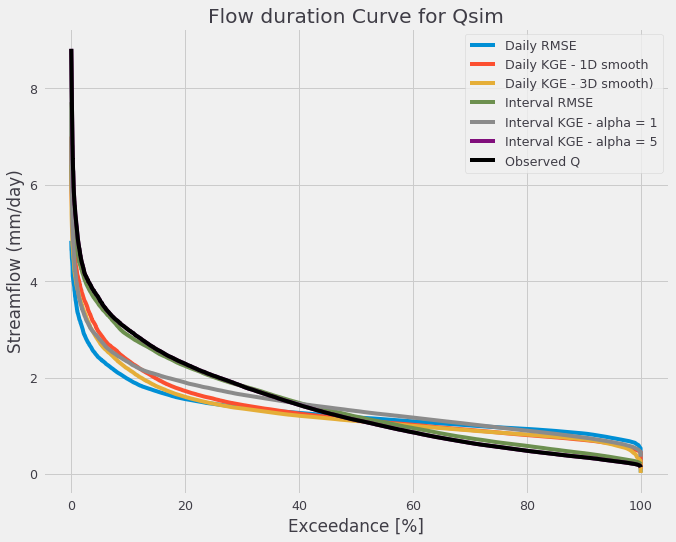

In [20]:
def fdc(ncdat, ncvar):
    '''
    Calculates exceedance flows
    '''
    fdata = ncdat[ncvar].values.flatten()  #Flow data
    fdatasort = np.sort(fdata)[::-1]
    fexceedance = np.arange(1.,len(fdatasort)+1) / len(fdatasort)
    return(fexceedance, fdatasort)
    
exceedance1, sort1 = fdc(out1, 'q_routed')
exceedance2, sort2 = fdc(out2, 'q_routed')
exceedance3, sort3 = fdc(out3, 'q_routed')
exceedance4, sort4 = fdc(out4, 'q_routed')
exceedance5, sort5 = fdc(out5, 'q_routed')
exceedance6, sort6 = fdc(out6, 'q_routed')
exceedance7, sort7 = fdc(out1, 'obsq')

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))
plt.plot(exceedance1*100, sort1, label = 'Daily RMSE')
plt.plot(exceedance2*100, sort2, label = 'Daily KGE - 1D smooth')
plt.plot(exceedance3*100, sort3, label = 'Daily KGE - 3D smooth)')
plt.plot(exceedance4*100, sort4, label = 'Interval RMSE')
plt.plot(exceedance5*100, sort5, label = 'Interval KGE - alpha = 1')
plt.plot(exceedance6*100, sort6, label = 'Interval KGE - alpha = 5')
plt.plot(exceedance6*100, sort6, label = 'Observed Q', color='black')
plt.xlabel("Exceedance [%]")
plt.title('Flow duration Curve for Qsim')
plt.ylabel("Streamflow (mm/day)")
plt.legend()
plt.show()

# Peak Flow Analysis

In [21]:
def ypeak(ncdat):
    '''
    Calculates the yearly peaks after 1980
    '''
    nc1 = ncdat.groupby('time.year').max()
    nc2 = nc1.where((nc1.year > 1979), drop = True)
    return(nc2)

Q1 = ypeak(out1)
Q2 = ypeak(out2)
Q3 = ypeak(out3)
Q4 = ypeak(out4)
Q5 = ypeak(out5)
Q6 = ypeak(out6)

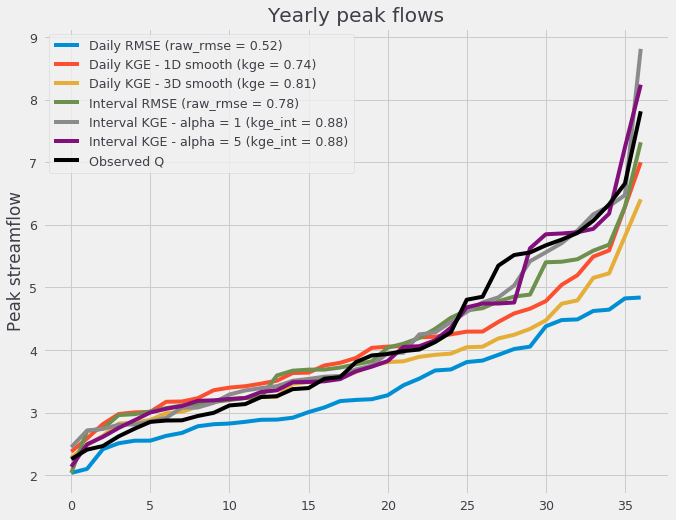

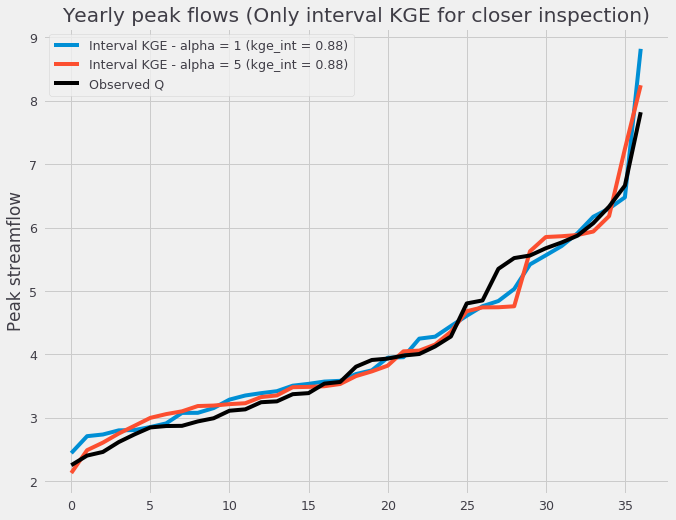

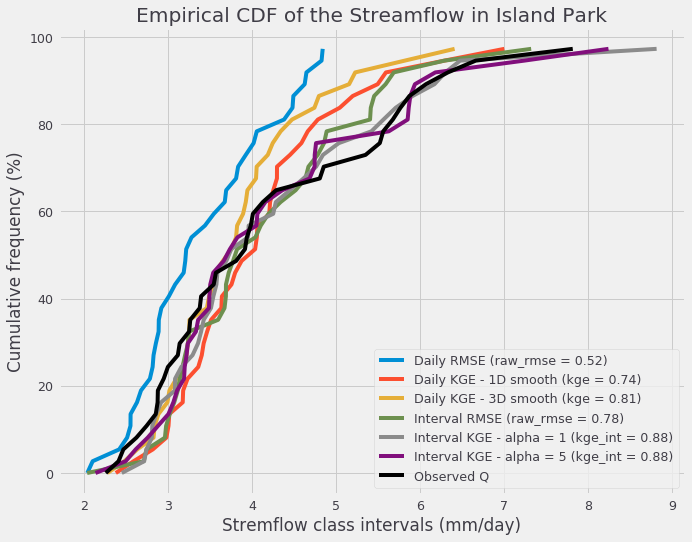

In [26]:
# Yearly peak flows
plt.figure(figsize=(10,8))
plt.plot(np.sort(Q1['q_routed']), label = 'Daily RMSE (raw_rmse = 0.52)')
plt.plot(np.sort(Q2['q_routed']), label = 'Daily KGE - 1D smooth (kge = 0.74)')
plt.plot(np.sort(Q3['q_routed']), label = 'Daily KGE - 3D smooth (kge = 0.81)')
plt.plot(np.sort(Q4['q_routed']), label = 'Interval RMSE (raw_rmse = 0.78)')
plt.plot(np.sort(Q5['q_routed']), label = 'Interval KGE - alpha = 1 (kge_int = 0.88)')
plt.plot(np.sort(Q6['q_routed']), label = 'Interval KGE - alpha = 5 (kge_int = 0.88)')
plt.plot(np.sort(Q1['obsq']), label = 'Observed Q', color='black')
plt.ylabel('Peak streamflow')
plt.title('Yearly peak flows')
plt.legend()
plt.show()

# Yearly peak flows (Only interval KGE for closer inspection)
plt.figure(figsize=(10,8))
plt.plot(np.sort(Q5['q_routed']), label = 'Interval KGE - alpha = 1 (kge_int = 0.88)')
plt.plot(np.sort(Q6['q_routed']), label = 'Interval KGE - alpha = 5 (kge_int = 0.88)')
plt.plot(np.sort(Q1['obsq']), label = 'Observed Q', color='black')
plt.ylabel('Peak streamflow')
plt.title('Yearly peak flows (Only interval KGE for closer inspection)')
plt.legend()
plt.show()


# Empirical CDF
plt.figure(figsize=(10,8))
#Q['q_routed'].plot.hist(weights=np.zeros_like(Q['q_routed']) + 100. / Q['q_routed'].size, cumulative=True,edgecolor='#4aaaaa')
plt.plot(np.sort(Q1['q_routed']), np.linspace(0, 100, len(Q1['q_routed']), endpoint=False), label = 'Daily RMSE (raw_rmse = 0.52)')
plt.plot(np.sort(Q2['q_routed']), np.linspace(0, 100, len(Q2['q_routed']), endpoint=False), label = 'Daily KGE - 1D smooth (kge = 0.74) ')
plt.plot(np.sort(Q3['q_routed']), np.linspace(0, 100, len(Q3['q_routed']), endpoint=False), label = 'Daily KGE - 3D smooth (kge = 0.81)')
plt.plot(np.sort(Q4['q_routed']), np.linspace(0, 100, len(Q4['q_routed']), endpoint=False), label = 'Interval RMSE (raw_rmse = 0.78)')
plt.plot(np.sort(Q5['q_routed']), np.linspace(0, 100, len(Q5['q_routed']), endpoint=False), label = 'Interval KGE - alpha = 1 (kge_int = 0.88)')
plt.plot(np.sort(Q6['q_routed']), np.linspace(0, 100, len(Q6['q_routed']), endpoint=False), label = 'Interval KGE - alpha = 5 (kge_int = 0.88)')
plt.plot(np.sort(Q1['obsq']), np.linspace(0, 100, len(Q1['obsq']), endpoint=False), label = 'Observed Q', color = 'black')
plt.ylabel('Cumulative frequency (%)')
plt.xlabel('Stremflow class intervals (mm/day)')
plt.title('Empirical CDF of the Streamflow in Island Park')
plt.legend()
plt.show()

In [27]:
def ncrange(ncdat, ncvar):
    '''
    Calculates the difference between maximum and minimum flows in the entire period
    '''
    varrange = ncdat[ncvar].max() - ncdat[ncvar].min()
    return(varrange.values)

print('''The ranges of streamflow are :
Interval KGE, alpha = 1 -> {0}
Interval KGE, alpha = 5 -> {1}
Observed Q              -> {2}
'''.format(ncrange(Q5, 'q_routed'), 
           ncrange(Q6, 'q_routed'),
           ncrange(Q1, 'obsq'),
          )
     )

The ranges of streamflow are :
Interval KGE, alpha = 1 -> 6.370348930358887
Interval KGE, alpha = 5 -> 6.110212326049805
Observed Q              -> 5.562070846557617



# FUSE OUTPUT FOR EXPERIMENT 5 (Interval KGE, alpha = 1)

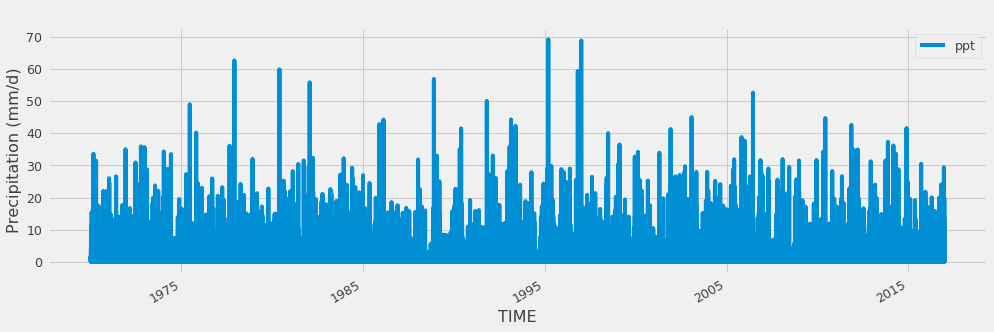

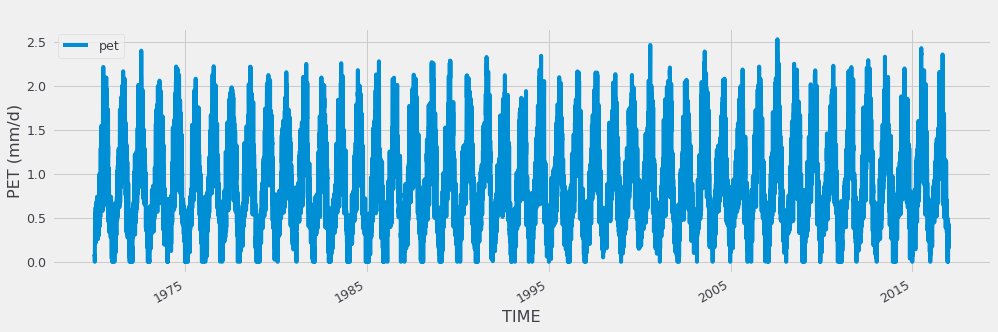

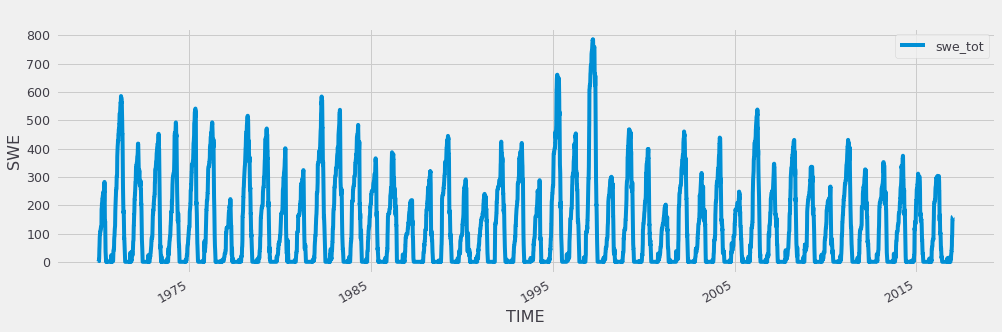

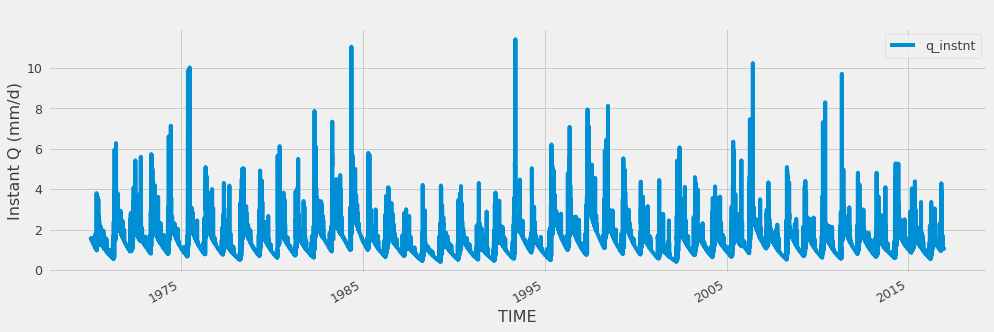

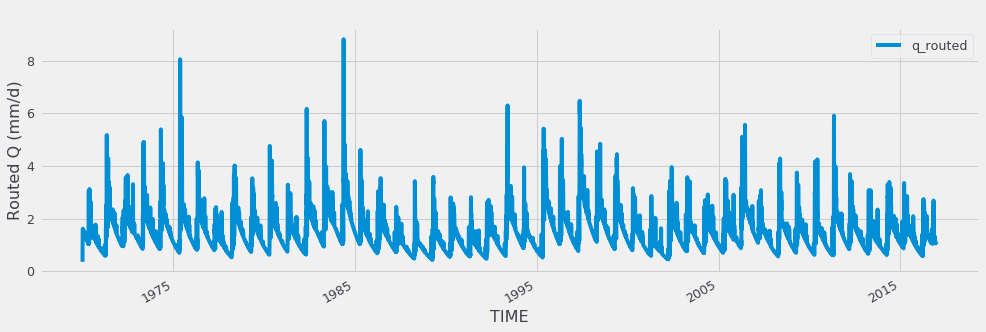

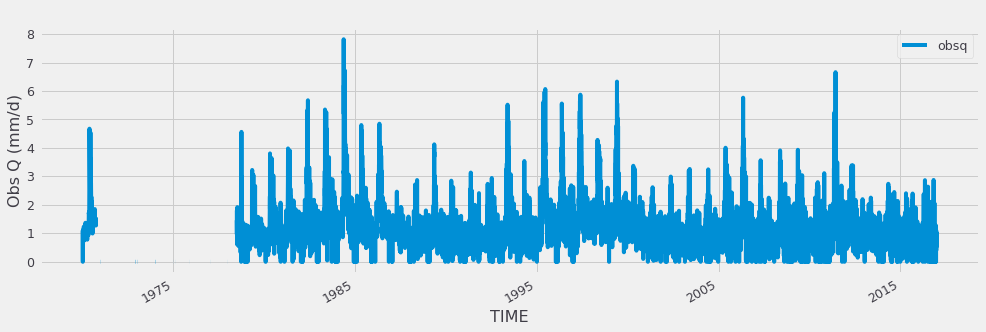

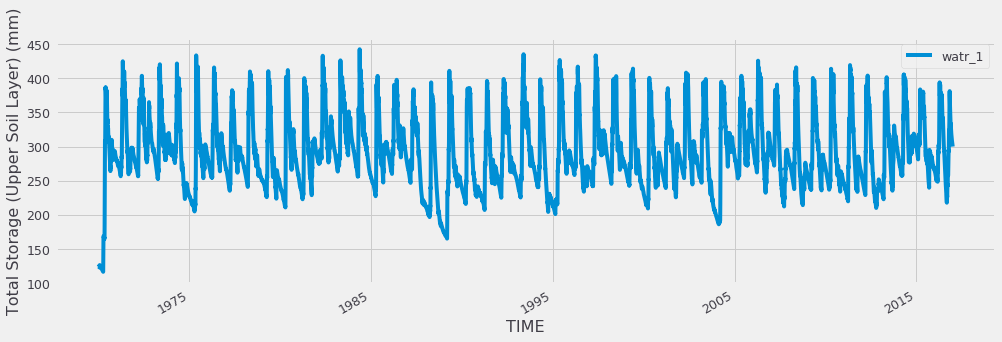

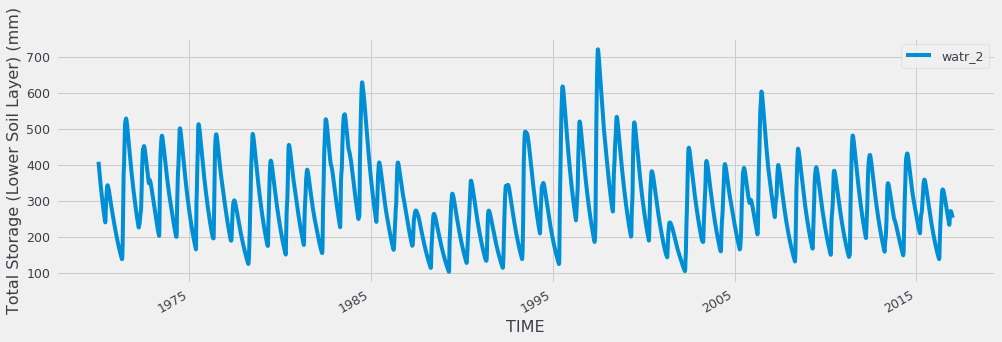

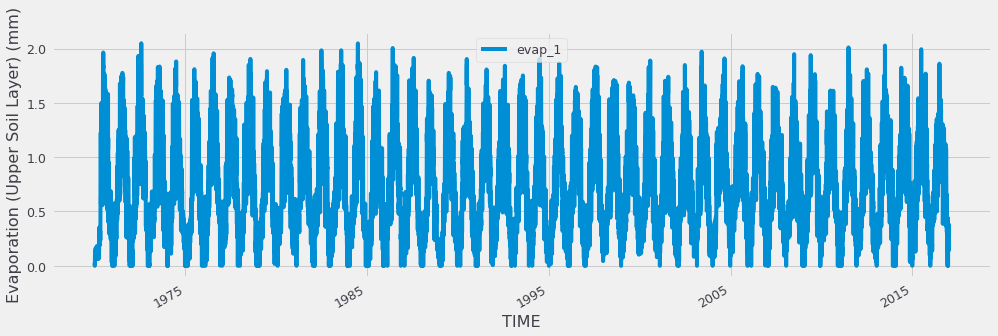

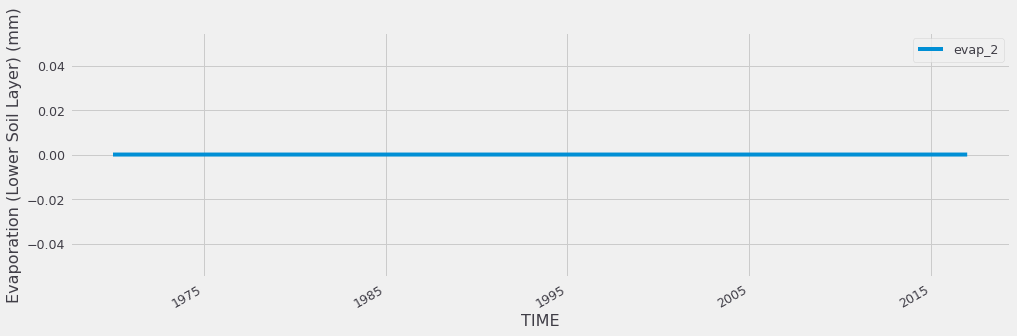

In [28]:
def plotncvar(ncdat, ncvar, xlabel, ylabel):
    plt.figure(figsize=(15, 5))
    ncdat[ncvar].plot()
    plt.title(' ')
    plt.ylabel(xlabel, fontsize = 16)
    plt.xlabel(ylabel, fontsize = 16)
    plt.legend()
    plt.show()
    
out = out5

plotncvar(out, 'ppt', 'Precipitation (mm/d)', 'TIME')
plotncvar(out, 'pet', 'PET (mm/d)', 'TIME')
plotncvar(out, 'swe_tot', 'SWE', 'TIME')
plotncvar(out, 'q_instnt', 'Instant Q (mm/d)', 'TIME')
plotncvar(out, 'q_routed', 'Routed Q (mm/d)', 'TIME')
plotncvar(out, 'obsq', 'Obs Q (mm/d)', 'TIME')
plotncvar(out, 'watr_1', 'Total Storage (Upper Soil Layer) (mm)', 'TIME')
plotncvar(out, 'watr_2', 'Total Storage (Lower Soil Layer) (mm)', 'TIME')
plotncvar(out, 'evap_1', 'Evaporation (Upper Soil Layer) (mm)', 'TIME')
plotncvar(out, 'evap_2', 'Evaporation (Lower Soil Layer) (mm)', 'TIME')

# Plot of FUSE Routed flow and Observation

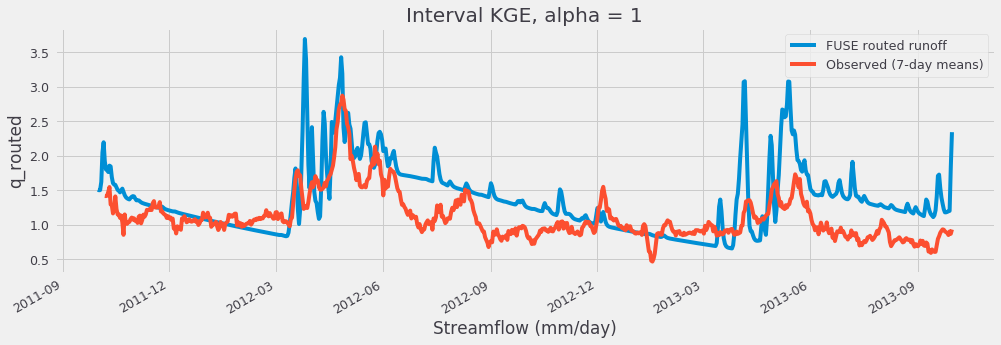

In [32]:
plt.figure(figsize=(15,5))
out['q_routed'].loc[starttime: endtime].plot(label = 'FUSE routed runoff')
#out2['obsq'].loc[starttime: endtime].plot(label = 'Observed flow (Unregulated monthly means)', color = 'grey')
out['obsq'].loc[starttime: endtime].rolling(time=7).mean().dropna('time').plot(label = 'Observed (7-day means)')
plt.xlabel('Streamflow (mm/day)')
plt.title('Interval KGE, alpha = 1')
plt.legend()
plt.show()